In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
from train_video import RateDistortionLoss
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
from utils import *
from torchvision import transforms
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def psnr(a: torch.Tensor, b: torch.Tensor, max_val: int = 255) -> float:
    return 20 * math.log10(max_val) - 10 * torch.log10((a - b).pow(2).mean())

In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open('data/custom_data/train/img00002.png')
print('size:', image.size) 

size: (1920, 1080)


In [4]:
model_path = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(model_path, use_auth_token=True).to(device)

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]


In [6]:
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
img_latents = pipe.vae.encode(image_tensor.to('cuda'))
img_latents = img_latents.latent_dist.sample()
noise_std = 0.1  # This value can be adjusted based on your specific needs
noise = torch.randn_like(img_latents) * noise_std
# img_latents = img_latents + noise
# img_latents = img_latents * scheduler.init_noise_sigma

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 48.69 MiB is free. Process 3055922 has 16.26 GiB memory in use. Including non-PyTorch memory, this process has 7.37 GiB memory in use. Of the allocated memory 6.97 GiB is allocated by PyTorch, and 154.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.44it/s]


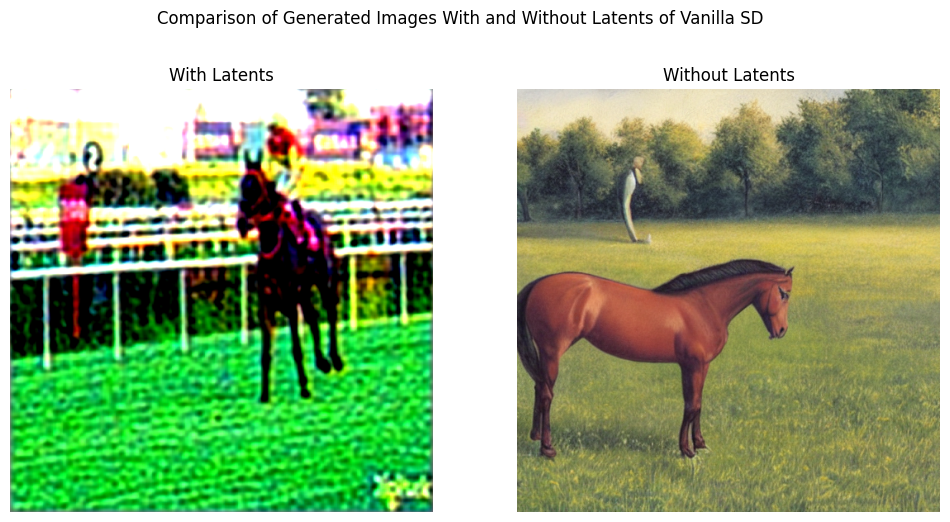

In [29]:
torch_device ='cuda'
generator = torch.Generator(device=torch_device )  # Place the generator on the CUDA device
generator.manual_seed(10)  

pred_with_latents = pipe(prompt="horse on grassy field with jockey", height=512, width=512,latents=img_latents).images[0]
pred = pipe(prompt="horse on grassy field with jockey", height=512, width=512).images[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image generated with latents on the first subplot
ax1.imshow(pred_with_latents)
ax1.set_title("With Latents")
ax1.axis('off')  # Turn off axis

# Display the image generated without latents on the second subplot
ax2.imshow(pred)
ax2.set_title("Without Latents")
ax2.axis('off')  # Turn off axis

# Add an overall title
plt.suptitle("Comparison of Generated Images With and Without Latents of Vanilla SD")

# Show the plot
plt.show()

In [30]:
# finetuned PSNR RESULTS 
transform2 = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor()
])

orig_image= transform2(image)

pred_l = transform2(pred_with_latents).to('cpu').squeeze(0)
pred_wl = transform2(pred).to('cpu').squeeze(0)

print('with latent: ',psnr(orig_image, pred_l).item())
print('without latent:', psnr(orig_image, pred_wl).item())


with latent:  60.42616653442383
without latent: 60.825218200683594


In [31]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler,UniPCMultistepScheduler

vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae", use_safetensors=True).to(torch_device)
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    model_path, subfolder="text_encoder", use_safetensors=True
).to(torch_device)
unet = UNet2DConditionModel.from_pretrained(
    model_path, subfolder="unet", use_safetensors=True
).to(torch_device)
scheduler = UniPCMultistepScheduler.from_pretrained(model_path, subfolder="scheduler")


In [32]:
prompt = ["horse on grassy field with jockey"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
batch_size = len(prompt)

In [33]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [34]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [35]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [36]:
random_latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device='cuda',
)
random_latents = random_latents * scheduler.init_noise_sigma
scheduler.set_timesteps(num_inference_steps)

In [37]:
def get_generated_images(latents):
    generated = []
    for i,t in enumerate(tqdm(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
        if i%10==0:
           # scale and decode the image latents with vae
            latents_scaled = 1 / 0.18215 * latents
            with torch.no_grad():
                recons_img = vae.decode(latents_scaled).sample  # Assuming 'sample' method is correct, might need '()' if it's a function call
            
            recons_img = (recons_img / 2 + 0.5).clamp(0, 1).squeeze()
            recons_img = (recons_img.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
            # psnr(orig_image, recons_img)
            recons_img = Image.fromarray(recons_img)
            generated.append(recons_img)  
        
    return generated,latents

In [38]:
generated_images, lz = get_generated_images(random_latents)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]


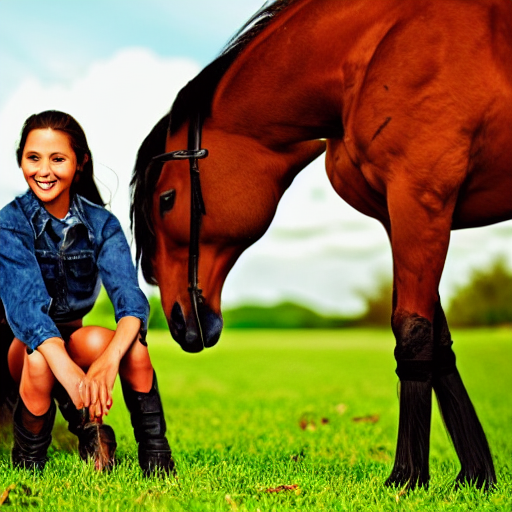

In [39]:
# scale and decode the image latents with vae
def get_decoded_images(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        recons_img = vae.decode(latents).sample  # Assuming 'sample' method is correct, might need '()' if it's a function call
    
    recons_img = (recons_img / 2 + 0.5).clamp(0, 1).squeeze()
    recons_img = (recons_img.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    # psnr(orig_image, recons_img)
    recons_img = Image.fromarray(recons_img)
    return recons_img
get_decoded_images(lz)

In [45]:
recons_img = get_decoded_images(lz)
recons_img
reconst_tensor = transform2(recons_img).to('cpu')

print('psnr without latent:', psnr(orig_image,reconst_tensor.squeeze(0),255).item())


psnr without latent: 56.551883697509766


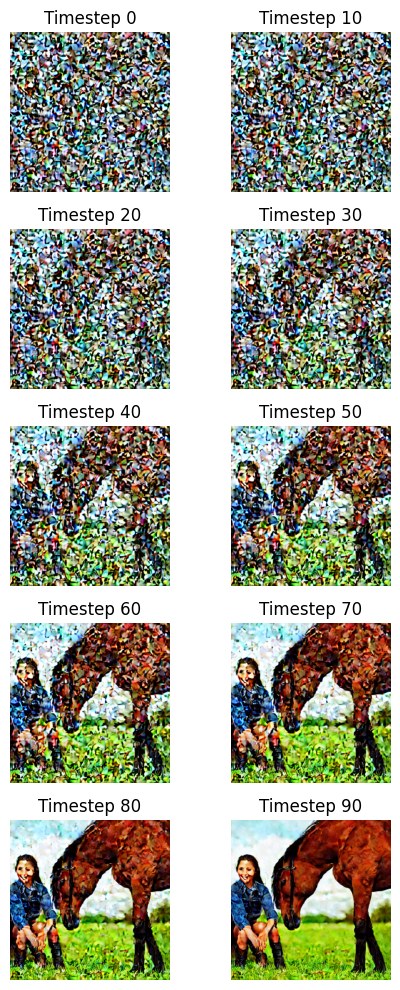

In [42]:
timesteps = [i * 10 for i in range(11)]

# Generate images for all specified timesteps
images = generated_images

# Create a figure with a 5x2 grid of axes
fig, axes = plt.subplots(5, 2, figsize=(5, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display each image in its respective subplot
for ax, img, t in zip(axes, images, timesteps):
    ax.imshow(img, cmap='gray')  # Assuming images are in grayscale for simplicity
    ax.set_title(f"Timestep {t}")
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()